In [1]:
import numpy as np
import typing as tp
import matplotlib.pyplot as plt
import sys

In [2]:
from BaselineSolver import BaselineSolver
from IterativeSolver import IterativeSolver
from GreedySolver import GreedySolver
from utils import run_tests, read_tests_simplex_in_ball, run_random_test

In [3]:
def get_baseline_test_results(dimension: int, number_tests: int, lowest_grid_density: float=100, highest_grid_density: float=10000,
                             silent=True) -> tp.Tuple[np.ndarray, np.ndarray]:
    times = []
    t_errors = []
    for _ in range(number_tests):
        time, t_error = run_random_test(BaselineSolver, dimension, 
                                        {'grid_density': np.exp(np.random.uniform(np.log(lowest_grid_density), np.log(highest_grid_density)))}, 
                                        read_tests_simplex_in_ball, f'./tests/{dimension}d/simplex-in-ball/', silent=silent)
        times.append(time)
        t_errors.append(t_error)
    
    return np.array(times), np.array(t_errors)

In [4]:
def get_iterative_test_results(dimension: int, number_tests: int, lowest_cap_grid_diameter: int=3, 
                               highest_cap_grid_diameter: int=10,
                              silent=True) -> tp.Tuple[np.ndarray, np.ndarray]:
    times = []
    t_errors = []
    for _ in range(number_tests):
        cap_grid_diameter = int(np.round(np.exp(np.random.uniform(np.log(lowest_cap_grid_diameter), np.log(highest_cap_grid_diameter)))))
        time, t_error = run_random_test(IterativeSolver, dimension, 
                                        {'cap_grid_diameter': cap_grid_diameter}, 
                                        read_tests_simplex_in_ball, f'./tests/{dimension}d/simplex-in-ball/', silent=silent)
        times.append(time)
        t_errors.append(t_error)
    
    return np.array(times), np.array(t_errors)

In [5]:
def get_greedy_test_results(dimension: int, number_tests: int, lowest_max_iteration: int=100, highest_max_iteration: int=500,
                             silent=True) -> tp.Tuple[np.ndarray, np.ndarray]:
    times = []
    t_errors = []
    for _ in range(number_tests):
        time, t_error = run_random_test(GreedySolver, dimension, 
                                        {'num_iterations': int(np.exp(np.random.uniform(np.log(lowest_max_iteration), np.log(highest_max_iteration))))}, 
                                        read_tests_simplex_in_ball, f'./tests/{dimension}d/simplex-in-ball/', silent=silent)
        times.append(time)
        t_errors.append(t_error)
    
    return np.array(times), np.array(t_errors)

In [6]:
def plot_test_results(times: np.ndarray, t_errors: np.ndarray, title: str, fit=True) -> None:
    t_errors_without_zeros = np.copy(t_errors)
    t_errors_without_zeros[t_errors_without_zeros == 0.] = 1e-16
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111)
    plt.xlabel('time, s')
    plt.ylabel('t_error')
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.scatter(times, t_errors_without_zeros)
    if fit:
        a, b = np.polyfit(np.log(times), np.log(t_errors_without_zeros), 1)
        plt.plot(times, np.exp(a * np.log(times) + b), 'r', label=f't_error ~ 1 / time^{-a:.2f}')
        plt.legend()
    plt.title(title)
    plt.savefig(f'figures/{title.replace(" ", "_").replace(",", "")}')

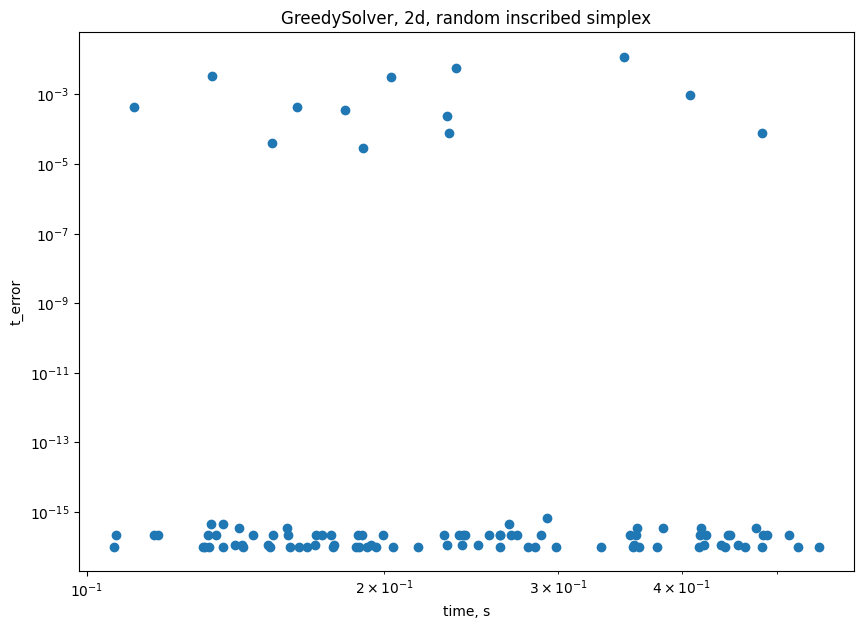

In [7]:
times_greedy_2d, errors_greedy_2d = get_greedy_test_results(2, 100, silent=True)
plot_test_results(times_greedy_2d, errors_greedy_2d, 'GreedySolver, 2d, random inscribed simplex', fit=False)

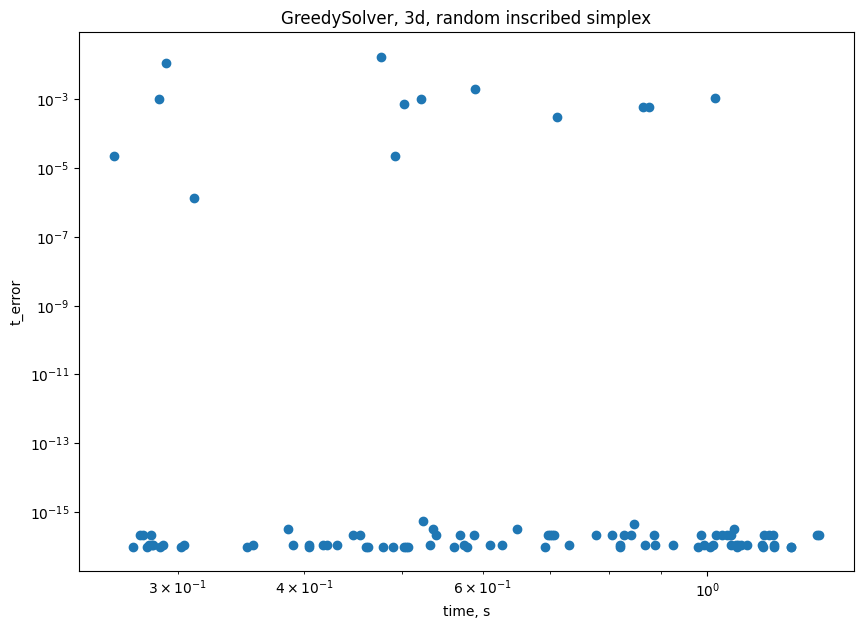

In [8]:
times_greedy_3d, errors_greedy_3d = get_greedy_test_results(3, 100, silent=True)
plot_test_results(times_greedy_3d, errors_greedy_3d, 'GreedySolver, 3d, random inscribed simplex', fit=False)

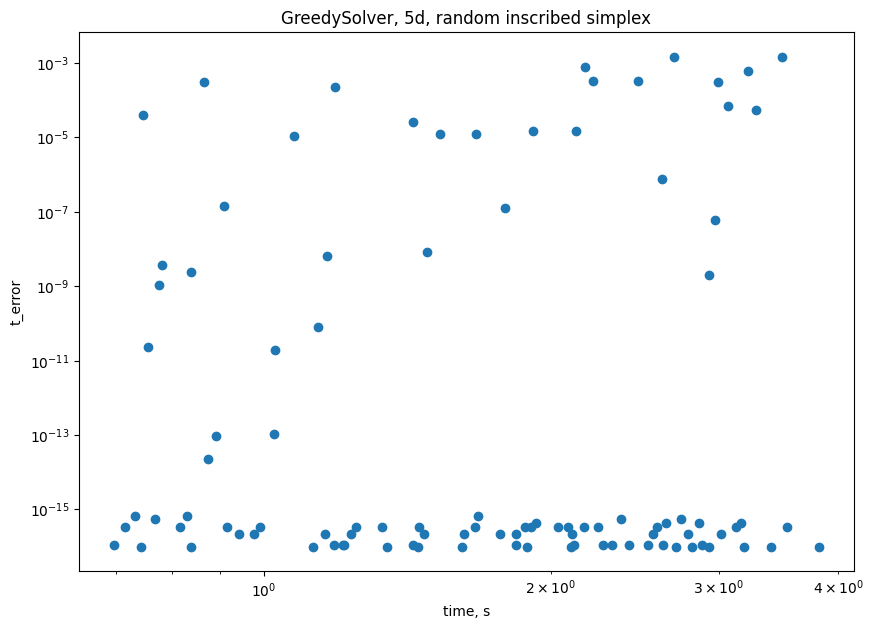

In [9]:
times_greedy_5d, errors_greedy_5d = get_greedy_test_results(5, 100, silent=True)
plot_test_results(times_greedy_5d, errors_greedy_5d, 'GreedySolver, 5d, random inscribed simplex', fit=False)

times_iterative_2d, errors_iterative_2d = get_iterative_test_results(2, 100, silent=True, highest_cap_grid_diameter=3)
plot_test_results(times_iterative_2d, errors_iterative_2d, 'IterativeSolver, 2d, n(n+1) caps with startovers, random inscribed simplex', fit=False)

times_iterative_3d, errors_iterative_3d = get_iterative_test_results(3, 100, silent=True, highest_cap_grid_diameter=3)
plot_test_results(times_iterative_3d, errors_iterative_3d, 'IterativeSolver, 3d, n(n+1) caps with startovers, random inscribed simplex', fit=False)

times_iterative_4d, errors_iterative_4d = get_iterative_test_results(4, 100, silent=True, highest_cap_grid_diameter=3)
plot_test_results(times_iterative_4d, errors_iterative_4d, 'IterativeSolver, 4d, n(n+1) caps with startovers, random inscribed simplex', fit=False)

times_iterative_5d, errors_iterative_5d = get_iterative_test_results(5, 100, silent=True, highest_cap_grid_diameter=3)
plot_test_results(times_iterative_5d, errors_iterative_5d, 'IterativeSolver, 5d, n(n+1) caps with startovers, random inscribed simplex', fit=False)

times_baseline_2d, errors_baseline_2d = get_baseline_test_results(2, 1000)

plot_test_results(times_baseline_2d, errors_baseline_2d, 'BaselineSolver, 2d, grid_from_cube, random inscribed simplex')

times_baseline_3d, errors_baseline_3d = get_baseline_test_results(3, 1000)

plot_test_results(times_baseline_3d, errors_baseline_3d, 'BaselineSolver, 3d, grid_from_cube, random inscribed simplex')

times_baseline_4d, errors_baseline_4d = get_baseline_test_results(4, 1000)

plot_test_results(times_baseline_4d, errors_baseline_4d, 'BaselineSolver, 4d, grid_from_cube, random inscribed simplex')

times_baseline_5d, errors_baseline_5d = get_baseline_test_results(5, 1000)

plot_test_results(times_baseline_5d, errors_baseline_5d, 'BaselineSolver, 5d, grid_from_cube, random inscribed simplex')